# Probabilistic Machine Learning
#### University of Tübingen, Summer Term 2021
## Exercise Sheet 5
&copy; 2021 Prof. Dr. Philipp Hennig & Jonathan Wenger

This sheet is **due on Tuesday June 1, 2021 at 10am sharp.**

---

# Kernels and Gaussian Processes

In this homework sheet you will implement Gaussian process regression. The first goal is to get a feel for kernels and the properties they encode about the corresponding functions. The second goal is to understand Gaussian processes by implementing a `GaussianProcess` class, which we will use to predict the daily number of reported COVID-19 cases in Germany as reported by the Robert Koch Institut.

In [1]:
# Plotting setup
import matplotlib.pyplot as plt
import datetime

# Make inline plots vector graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")
# %config InlineBackend.figure_format='svg'

# Package imports
from functools import partial
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.linalg import det, solve

In [2]:
# Seeded random number generator
rng = np.random.default_rng(42)

## Kernels

Kernels are symmetric positive definite functions, which can be thought of as measuring the similarity between two points in the input space. As covariance functions of random processes they are often used to encode properties of a function which we are trying to model. Classic examples are its smoothness or periodicity.

**Task:** Implement the kernels below based on the given definitions. If only $X_0$ is given the kernel evaluated pairwise $k(X_0, X_0)$ should be returned.

*Hint:* The function `scipy.spatial.distance` may be helpful.

#### Polynomial Kernel

$$k(x_0, x_1) = (x_0^\top x_1 + c)^d$$

where $c\geq 0$ is a constant and $d \in \mathbb{N}$ the degree of the polynomial.

In [3]:
def polynomial(x0, x1=None, constant=0, exponent=1):
    """x0, x1 \in R^{D \times N}"""
    if x1 is None:
        x1 = x0
    
    return (x0.T@x1 + constant)**exponent

#### Exponentiated Quadratic Kernel

Also known as radial basis function (RBF) or squared exponential kernel.

$$k(x_0, x_1) = \exp \left(-\frac{\lVert x_0 - x_1 \rVert^2}{2 \ell^2}\right)$$

with lengthscale $\ell \in \mathbb{R}$.

In [4]:
def expquad(x0, x1=None, lengthscale=1.0):
    """x0, x1 \in R^{D \times N}"""
    if x1 is None:
        x1 = x0

    d = cdist(x0.T, x1.T)**2
    return np.exp(-d / (2 * lengthscale**2))

#### Rational Quadratic Kernel

$$k(x_0, x_1) = \exp \left(-\frac{\lVert x_0 - x_1 \rVert^2}{2 \ell^2}\right)$$

with lengthscale $\ell \in \mathbb{R}$ and scale mixture $\alpha > 0$.

In [5]:
def ratquad(x0, x1=None, lengthscale=1.0, alpha=0.01):
    """x0, x1 \in R^{D \times N}"""
    if x1 is None:
        x1 = x0

    d = cdist(x0.T, x1.T)**2
    return (1 + d/(2 * alpha * lengthscale**2)) ** (-alpha)

#### Periodic Kernel

$$k(x_0, x_1) = \exp \left(-\frac{2 \sin^2(\pi \lVert x_0 - x_1 \rVert / p)}{\ell^2}\right)$$

with lengthscale $\ell \in \mathbb{R}$ and period $p > 0$.

In [6]:
def periodic(x0, x1=None, lengthscale=1.0, period=2 * np.pi):
    """x0, x1 \in R^{D \times N}"""
    if x1 is None:
        x1 = x0
    
    d = cdist(x0.T, x1.T)
    return np.exp(-2 * np.sin(np.pi * d / period)**2 / lengthscale**2)

#### Custom kernel

Define a custom kernel 
$$k(x_0, x_1) = \langle \varphi(x_0), \varphi(x_1)\rangle$$
for a given feature transformation $\varphi$.

In [7]:
def feature_trafo(X):
    """X \in R^{1 \times N}, returns R^{11 \times N}"""
    return (X > np.linspace(-5, 5, 11)[:, None]).astype(float)

In [8]:
def custom_kernel(x0, x1=None, phi=feature_trafo):
    """x0, x1 \in R^{D \times N}"""
    if x1 is None:
        x1 = x0

    y0, y1 = phi(x0), phi(x1)
    return y0.T @ y1

**Task:** Plot kernel matrices and samples for some synthetic 1D data for the kernels you just defined.

In [9]:
def plot_kernel_matrix(ax, X, kernel, **kernkwargs):
    ax.imshow(kernel(X, **kernkwargs))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
def plot_prior_samples(ax, X, kernel, nsamples=5, rng=np.random.default_rng(), **kernkwargs):
    n = len(X.T)
    mean = np.zeros(n)
    cov = kernel(X, **kernkwargs)
    f = rng.multivariate_normal(mean, cov, size=5)

    ax.set_yticks([])
    ax.plot(X.flatten(), f.T, color="C0", alpha=0.5)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f$")

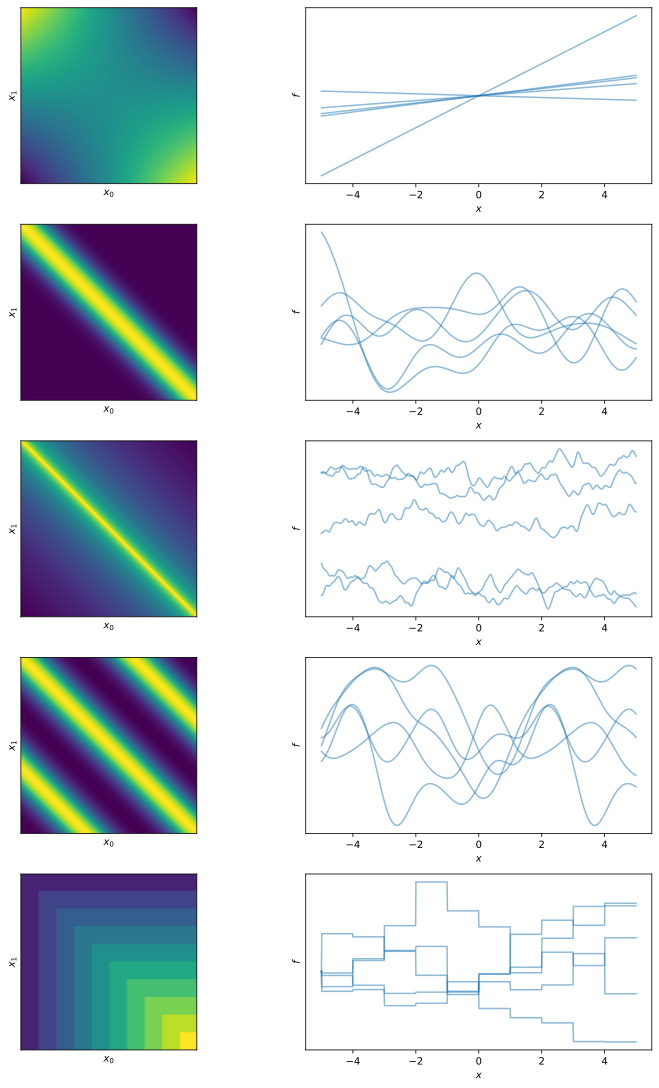

In [10]:
# Generate synthetic data and plot
N = 1000
x = np.linspace(-5, 5, N)[None, :]

fig, ax = plt.subplots(5, 2, figsize=(10, 15), constrained_layout=True)
plot_kernel_matrix(ax[0, 0], x, polynomial)
plot_prior_samples(ax[0, 1], x, polynomial)
plot_kernel_matrix(ax[1, 0], x, expquad)
plot_prior_samples(ax[1, 1], x, expquad)
plot_kernel_matrix(ax[2, 0], x, ratquad)
plot_prior_samples(ax[2, 1], x, ratquad)
plot_kernel_matrix(ax[3, 0], x, periodic)
plot_prior_samples(ax[3, 1], x, periodic)
plot_kernel_matrix(ax[4, 0], x, custom_kernel)
plot_prior_samples(ax[4, 1], x, custom_kernel)

Notice that apart from the polynomial kernel, the above kernels all only depend on the distance between points, not their absolute position. Such kernels are called *stationary*.

### Combining Kernels

Kernels can be combined to represent a richer class of functions. In particular, kernels can be multiplied and added together.

#### Multiplying Kernels

**Task:** Define a quadratic kernel and a locally periodic kernel using a product of exactly two kernels you defined above.

In [11]:
def quadratic(x0, x1=None):
    k1 = k2 = polynomial(x0, x1)
    return k1 * k2

In [12]:
def locally_periodic(x0, x1=None):
    k1 = custom_kernel(x0, x1)
    k2 = periodic(x0, x1, lengthscale=10, period=0.1*np.pi)
    return k1 * k2

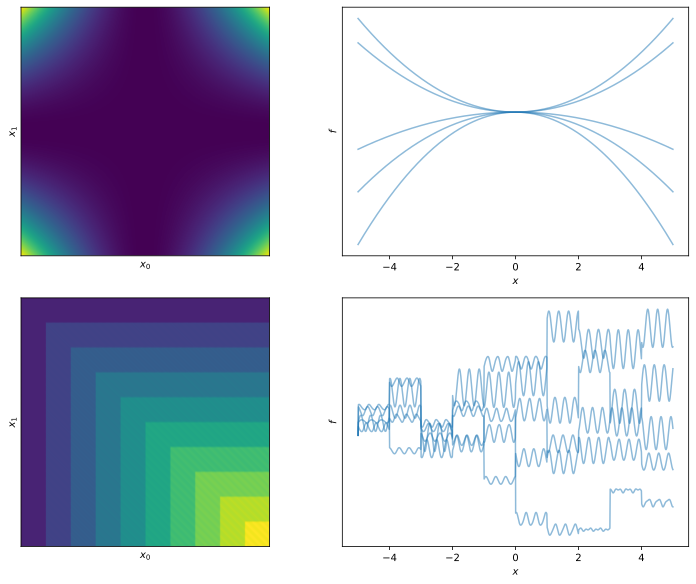

In [13]:
# Generate synthetic data and plot
N = 1000
x = np.linspace(-5, 5, N)[None, :]

fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
plot_kernel_matrix(ax[0, 0], x, quadratic)
plot_prior_samples(ax[0, 1], x, quadratic)
plot_kernel_matrix(ax[1, 0], x, locally_periodic)
plot_prior_samples(ax[1, 1], x, locally_periodic)

#### Adding Kernels

**Task:** Define a kernel representing a global pattern which has periodic local structure using a sum of two (scaled) kernels.

In [14]:
def sum_kernel(x0, x1=None, lengthscale1=1, lengthscale2=5, period=0.2*np.pi):
    k1 = expquad(x0, x1, lengthscale=lengthscale1)
    k2 = periodic(x0, x1, lengthscale=lengthscale2, period=period)
    return k1 + k2

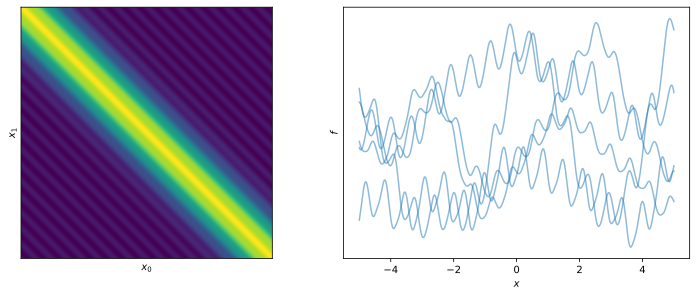

In [15]:
# Generate synthetic data and plot
N = 1000
x = np.linspace(-5, 5, N)[None, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plot_kernel_matrix(ax[0], x, sum_kernel)
plot_prior_samples(ax[1], x, sum_kernel)

**Task:** Plot kernel matrices and samples for the same synthetic 1D data.

(see above)

## Implementing Gaussian Processes

**Task:** Implement Gaussian process regression by completing the class implementation below. 

*Hint:* One way to implement the solution of linear systems $(K+\sigma^2I)^{-1}y$ arising in GP inference is via a Cholesky decomposition $K+\sigma^2I = LL^\top$. See also [`cho_factor`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cho_factor.html#scipy.linalg.cho_factor) and [`cho_solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cho_solve.html#scipy.linalg.cho_solve).

In [16]:
from scipy.linalg import cho_factor, cho_solve

In [17]:
class GaussianProcess:
    """Gaussian process regression.
    
    Parameters
    ----------
    mean :
        Mean function.
    cov :
        Covariance function / kernel.
    sigma :
        Scalar observation noise.
    """

    def __init__(self, mean, cov, sigma=10 ** -6):
        self.m = mean     # Prior mean
        self.k = cov      # Prior kernel
        self.mp = mean    # Posterior mean
        self.kp = cov     # Posterior kernel
        self.sigma = sigma
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        gram = self.k(X) + (self.sigma**2 * np.eye(len(y)))
        gain = lambda x: cho_solve(cho_factor(gram.T), self.k(x, X).T).T
        self.mp = lambda x: self.m(x) + gain(x)@(y - self.m(X))
        self.kp = lambda x: self.k(x, x) - gain(x)@self.k(X, x)

    def predict(self, Xnew):
        return self.mp(Xnew), self.kp(Xnew)
    
    def sample(self, Xnew, size, rng=None):
        if rng is None:
            rng = np.random.default_rng()
        return rng.multivariate_normal(self.mp(Xnew), self.kp(Xnew), size=size)

    def log_marginal_likelihood(self, **hyperparams):
        X = self.X
        y = self.y
        G = (np.eye(len(y)) * self.sigma**2) + self.k(X, **hyperparams)
        E = (y - self.m(X)).T @ cho_solve(cho_factor(G), y - self.m(X))
        return -1/2 * (len(y)*np.log(2*np.pi) + E) #  - 1/2 * np.log(det(G))  (Taken out because det(G) is 0 in RKI data)

**Task:** Test your implementation by fitting a Gaussian process to the synthetically generated test data.

In [18]:
# Test function (changed shapes to those used in lecture)
X = np.sort(rng.uniform(-5,5,20))[None, :]
y = (np.sin(X) + 0.1 * rng.normal(size=X.shape[1])[None, :]).flatten()

In [19]:
# Gaussian process (changed shapes to those used in lecture)
mu = lambda x: np.zeros(shape=(x.shape[1]))
cov = expquad
g = GaussianProcess(mu, cov, sigma=10 ** -1)
g.fit(X, y)

Xnew = np.linspace(-6.5, 6.5, 100)[None, :]
ypred = g.predict(Xnew)
g.log_marginal_likelihood()

-23.507255008581204

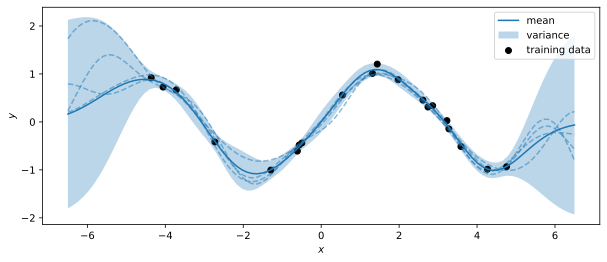

In [20]:
# Plot

def plot_gp(Xnew, ypred, samples=None, traindata=None):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    
    ax.plot(Xnew.flatten(), ypred[0], label="mean")
    ax.fill_between(
        x=Xnew.flatten(),
        y1=ypred[0].flatten() - 2 * np.sqrt(np.diag(ypred[1])),
        y2=ypred[0].flatten() + 2 * np.sqrt(np.diag(ypred[1])),
        alpha=0.3,
        label="variance"
    )
    
    if samples is not None:
        ax.plot(Xnew.flatten(), samples.T, linestyle="--", color="C0", alpha=0.5)
    
    if traindata is not None:
        ax.scatter(traindata[0], traindata[1], color="k", label="training data")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend()
        
    plt.show()
    
plot_gp(Xnew, ypred, samples=g.sample(Xnew, 4), traindata=(X,y))

## German COVID-19 Data

We will now use the Gaussian process class you just implemented to predict the future development of COVID-19 numbers in Germany.

**Disclaimer:** *Although the exercise uses real data, it does not aspire to satisfy the standards of epidemiology or public policy making. It is deliberately simple and designed to be feasible within the scope of this lecture course. Do not mistake it for a thorough scientific analysis, and do not draw overly confident conclusions from it.*

**Task:** Download the COVID-19 data for Germany from the [Robert Koch Institute](https://www.rki.de/).

In [23]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Link to current data of the RKI
url = "https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data"

# Read CSV data from URL
data_rki = pd.read_csv(url)

# Create dataframe of number of new cases
data_rki_cases = pd.DataFrame(
    data_rki[data_rki.NeuerFall > -1].groupby(["Meldedatum"]).AnzahlFall.sum()
)
data_rki_cases = data_rki_cases.rename(columns={"AnzahlFall": "new-cases"})
data_rki_cases.index.name = "date"

# Reset index and parse dates
data_rki_cases = data_rki_cases.reset_index()
data_rki_cases["date"] = pd.to_datetime(data_rki_cases.date, format="%Y-%m-%d")

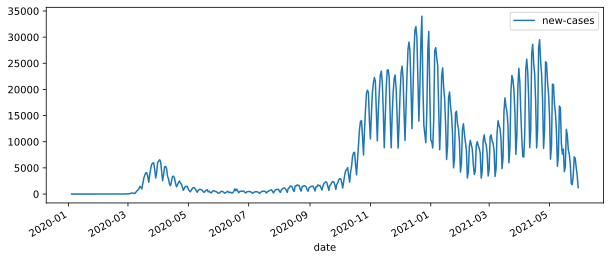

In [24]:
data_rki_cases.plot(x="date", y="new-cases", figsize=(10, 4))
plt.show()

### Data Transformation

In order to satisfy the assumptions a GP model makes implicitly we will transform the non-negative count data with a $\log$-transform.

**Task:** Implement a transformation (and its inverse) using the logarithm, shifting and scaling such that your data has range $\subset (-\infty, \infty)$, is centered and has variance one.

In [25]:
def transform_data(X):
    """Log-transform and standardize data."""
    return ((Z := np.log(X)) - (m := Z.mean())) / (s := Z.std()), (m, s)

def retransform_data(Z, mu, sigma):
    """Transform back to original data range."""
    return np.exp(Z*sigma + mu)

In [26]:
data_trafo, (Z_mean, Z_sigma) = transform_data(data_rki_cases["new-cases"])
data_rki_cases["new-cases-transformed"] = data_trafo
data_rki_cases["days"] = (data_rki_cases["date"] - data_rki_cases["date"][0]).dt.days
data_rki_cases.describe()

,new-cases,new-cases-transformed,days
count,480.000000,4.800000e+02,480.000000
mean,7669.012500,-5.921189e-17,271.991667
std,8412.951814,1.000000e+00,139.596211
min,1.000000,-3.529234e+00,0.000000
25%,748.750000,-5.279212e-01,152.750000
50%,3738.500000,2.013481e-01,272.500000
75%,12719.500000,7.565408e-01,392.250000
max,33999.000000,1.202489e+00,512.000000


In [35]:
# Data (changed shapes to those used in lecture)
X = data_rki_cases["days"].to_numpy()[None, :]
y = data_rki_cases["new-cases-transformed"].to_numpy().flatten()

### Prior Choice

**Task:** Implement a custom kernel (e.g. by combining kernels you previously defined) which encodes any prior assumptions you might have about the COVID numbers. You can check how your prior assumptions translate into the functions your GP represents by drawing samples from the prior and comparing them to the transformed data.

In [36]:
# Custom kernel
def custom_kernel(x0, x1=None, l1=100, l2=5, p=7):
    return 10*sum_kernel(x0, x1, l1, l2, p)

In [37]:
# Gaussian process (changed shapes to those used in lecture)
cov = custom_kernel
g = GaussianProcess(mu, cov, sigma=10 ** -1)

Xnew = np.linspace(0, np.max(X) + 100, 1000)[None, :]
ypred = g.predict(Xnew)

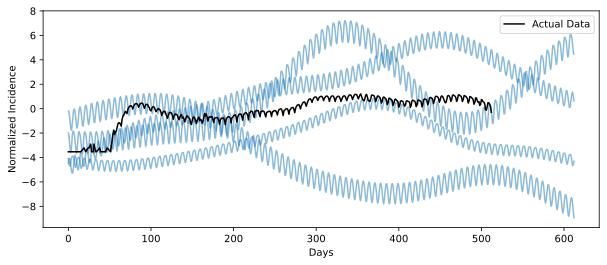

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))

# Samples
ax.plot(Xnew.flatten(), g.sample(Xnew, size=4).T, linestyle="-", color="C0", alpha=0.5)

# Data
ax.plot(X.flatten(), y, color="k", label="Actual Data")

ax.set_xlabel("Days")
ax.set_ylabel("Normalized Incidence")
ax.legend()

plt.show()

### GP Regression and Extrapolation

**Task:** Apply your GP model to the transformed incidence data from the RKI. What can you say about the prediction of your model for the next 100 days?

In [31]:
g.fit(X, y)
ypred = g.predict(Xnew)
g.log_marginal_likelihood()

-1926.6899973092218

In [32]:
# Retransform incidence
mean_retrafo = retransform_data(ypred[0], Z_mean, Z_sigma).flatten()
quantile_retrafo = np.quantile(
    retransform_data(g.sample(Xnew, size=10000), Z_mean, Z_sigma), q=(0.025, 0.975), axis=0
)

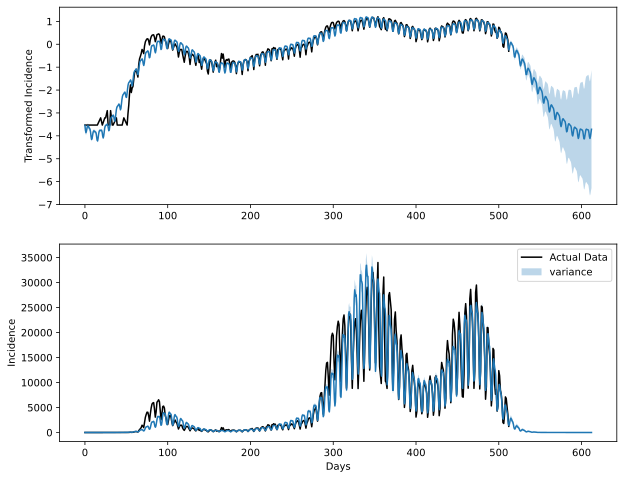

In [33]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))

# Transformed incidence
axs[0].plot(X.flatten(), y, color="k", label="Actual Data")
axs[0].plot(Xnew.flatten(), ypred[0], label="mean")
axs[0].fill_between(
    x=Xnew.flatten(),
    y1=ypred[0].flatten() - 2 * np.sqrt(np.diag(ypred[1])),
    y2=ypred[0].flatten() + 2 * np.sqrt(np.diag(ypred[1])),
    alpha=0.3,
    label="variance"
)

# Incidence
axs[1].plot(X.flatten(), data_rki_cases["new-cases"], color="k", label="Actual Data")
axs[1].plot(Xnew.flatten(), mean_retrafo)
axs[1].fill_between(
    x=Xnew.flatten(),
    y1=quantile_retrafo[0, :],
    y2=quantile_retrafo[1, :],
    alpha=0.3,
    label="variance"
)

axs[0].set_ylabel("Transformed Incidence")
axs[1].set_ylabel("Incidence")
axs[1].set_xlabel("Days")
axs[1].legend()
plt.show()

**Question:** What observations does your prior choice encode? How good is the fit? How could it be improved *automatically*?

It encodes the periodicity of 1 week (p=7) and the observed lengthscales of the periodic and non-periodic components. The kernel parameters (like the periodicity) can be automatically optimized by hierarchical Bayesian inference (Maximum Likelihood on the marginal log likelihood). The fit is surprisingly confident that cases will not rise again (in the near future); it definitely fails in the beginning, where the transformed data also visibly does not follow the Gaussian / smooth shape that it has elsewhere.